In [1]:
import pandas as pd
import os
import json
import spacy
import pickle
import re
from tqdm import tqdm
from os.path import join
import matplotlib.pyplot as plt
import matplotlib.patches as patches
from skimage import io

tqdm.pandas()

In [2]:
split = 'testB'
dataset = 'refcoco'

In [3]:
base_dir = '/home/simeon/Dokumente/Datasets/'  # path to data root (with refcoco, refcoco+, refcocog subdirs)
refcoco_dir = join(base_dir, dataset)

In [4]:
def get_data(ann_file, instances_file, explode_sents=True):
    """

    Get RefCOCO / RefCOCO+ Data

    Parameters
    ----------
    ann_file : str
        Path to annotation file.
    instances_file : str
        Path to instances file.
    explode_sents : bool, optional
        Specify whether sentences for the same object shall be
        bundled in lists (False) or split up into separate entries (True).
        The default is True.

    Returns
    -------
    merged : pd.DataFrame
        A data frame containing RefCOCO(+) annotations and instances.

    """

    # read annotation file
    with open(ann_file, "rb") as f:
        anns = pd.DataFrame(pickle.load(f))

    if explode_sents:
        # separate entries for sentences
        anns = anns.drop(columns=["sent_ids", "file_name"]).explode("sentences")

        # extract sentences and sent ids
        anns["sent"] = anns.sentences.map(lambda x: x["sent"])
        anns["sent_id"] = anns.sentences.map(lambda x: x["sent_id"])

        anns = anns.drop(columns="sentences")

    # read instances file
    with open(instances_file) as f:
        instances = json.load(f)

    # get instance annotations and category descriptions
    instance_anns = pd.DataFrame(instances["annotations"]).drop(
        columns=["image_id", "category_id"]
    )
    instance_cats = pd.DataFrame(instances["categories"])

    # merge sentences and instance annotations
    merged = pd.merge(anns, instance_anns, left_on="ann_id", right_on="id").drop(
        columns="id"
    )

    # merge sentences/instance annotations and category descriptions
    merged = pd.merge(merged, instance_cats, left_on="category_id", right_on="id").drop(
        columns="id"
    )

    return merged


def read_json_file(file):
    """
    Read a json file and return the data

    Parameters
    ----------
    file : str
        Path to the file.

    Returns
    -------
    data : dict
        Content of the file.

    """
    with open(file) as f:
        data = json.load(f)
    return data


def analyze_filename(filename):
    """
    Analyze the filename of a given caption file

    Parameters
    ----------
    filename : str
        Name of the file.

    Returns
    -------
    dict
        Information about the file: dataset, split, method, rationality (lambda).

    """
    dataset, split, remain = filename.split("_", 2)
    method = re.search(r"([a-z_]+)_l", remain)
    method = method.group(1) if method else "annotation"
    _lambda = re.search(r"l-([\d\-a-z]+)_", remain)
    _lambda = _lambda.group(1) if _lambda else "na"
    return {"dataset": dataset, "split": split, "method": method, "lambda": _lambda}


def create_url(imgid):
    url_template = "http://images.cocodataset.org/train2017/{id}.jpg"
    return url_template.format(id=str(imgid).rjust(12, "0"))

In [5]:
def patches_from_bb(e, linewidth=2, edgecolor="g", facecolor="none"):
    bbox = e.bbox
    # Create a Rectangle patch
    return patches.Rectangle(
        (bbox[0], bbox[1]),
        bbox[2],
        bbox[3],
        linewidth=linewidth,
        edgecolor=edgecolor,
        facecolor=facecolor,
    )


def display_target_distractors(
    entry,
    refcoco_data=None,
    linewidth=2,
    target_color="g",
    distractor_color="r",
    facecolor="none",
    save=False
):
    
    # Create figure and axes
    fig, ax = plt.subplots(figsize=(10, 10))

    # Retrieve & display the image
    url = create_url(entry["image_id"])
    image = io.imread(url)
    ax.imshow(image)

    # Add the patch to the Axes
    ax.add_patch(
        patches_from_bb(
            entry, edgecolor=target_color, linewidth=linewidth, facecolor=facecolor
        )
    )

    if type(refcoco_data) == pd.core.frame.DataFrame:

        # add patches for distractors
        add_patch = lambda x: ax.add_patch(
            patches_from_bb(
                x, edgecolor=distractor_color, linewidth=linewidth, facecolor=facecolor
            )
        )

        distractors = (
            refcoco_data.loc[refcoco_data.image_id == entry.image_id]
            .loc[refcoco_data.ref_id != entry.ref_id]
            .groupby("ref_id")
            .first()
        )

        distractors.apply(lambda x: add_patch(x), axis=1)
        
    ax.axes.xaxis.set_visible(False)
    ax.axes.yaxis.set_visible(False)
    
    if save:
        filename = f'example_{entry.image_id}_{entry.ref_id}.png'
        plt.savefig(filename, bbox_inches='tight')
        print(f'saved to {filename}')

    plt.show()
    
def show_rexps(entry, names, save=False):
  
    sents = [entry[name] for name in names]
    
    ref_id = entry.ref_id
    print('ref_id:', ref_id)
    
    if type(refcoco_data) == pd.core.frame.DataFrame: 
        ann_sents = refcoco_data.loc[refcoco_data.ref_id == ref_id].sent.values
        print('Annotations:')
        for s in ann_sents:
            print('\t', s)
    else:
        ann = entry.sent
        print('Annotation:', ann)
        
    
    print('\n-------------------')
    for i, (name, sent) in enumerate(zip(names, sents)):
        print('{name}: {sent}'.format(name=name, sent=sent))
    print('-------------------\n')
    
    display_target_distractors(entry, refcoco_data, save=save)
    
    print('\n####################################\n')

In [6]:
ann_file = join(refcoco_dir, 'refs(umd).p' if dataset == 'refcocog' else 'refs(unc).p')
instances_file = join(refcoco_dir, 'instances.json')

refcoco_data = get_data(ann_file, instances_file)

In [7]:
model_exp_dir = f'../data/model_expressions/{dataset.replace("+", "plus")}/filtered/'
os.path.isdir(model_exp_dir)

True

In [8]:
all_rexps = refcoco_data.copy()
all_rexps = all_rexps.loc[all_rexps.split == split]\
    .reset_index()\
    .groupby('ref_id').first()\
    .reset_index()

files = [f for f in os.listdir(model_exp_dir) if '_'+split+'_' in f] 

In [9]:
for file in files:
    file = join(model_exp_dir, file)

    with open(file) as f:
        name = os.path.split(file)[-1].replace('_cleaned_filtered.json', '')
        #print(name)
        data = json.load(f)
        data = pd.DataFrame(data)
        data = data.rename(columns={'caption': name, 'target': 'ann_id'}).drop(columns=['distractors']).set_index('ann_id')

        all_rexps = pd.merge(
            all_rexps, 
            data, 
            left_on = 'ann_id',
            right_on = 'ann_id'
        )

In [10]:
names = sorted([c for c in all_rexps.columns if re.search(fr'refcoco[\+g]?_{split}_', c)])

In [11]:
show = lambda x: show_rexps(x, names, save=False)  # set save to True for export
rexp_iter = all_rexps.iterrows()

In [12]:
refcoco_testb = [362, 837, 1645]
refcocop_testb = [432, 851, 1252]

ref_id: 362
Annotations:
	 green cup in background o right
	 green carton at right
	 the green cup on the top right has the word after on it

-------------------
refcoco_testB_annsample: green cup in background o right
refcoco_testB_beam_l-na_r-na: green bottle
refcoco_testB_greedy_l-na_r-na: green bottle
refcoco_testB_predfuse_es_l-0-3_r-na: green green green green green mug right
refcoco_testB_predfuse_es_l-0-5_r-na: top right green bottle
refcoco_testB_predfuse_es_l-0-7_r-na: green bottle
refcoco_testB_rsa_l-na_r-0-5: green bottle
refcoco_testB_rsa_l-na_r-1-0: green bottle
refcoco_testB_rsa_l-na_r-5-0: top right drink
-------------------



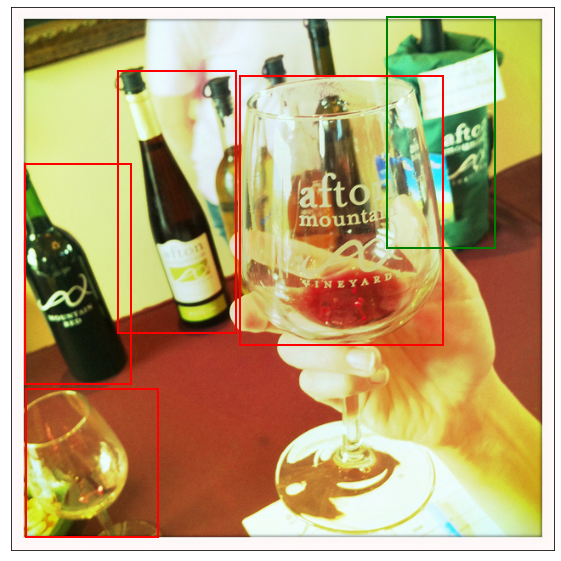


####################################

ref_id: 837
Annotations:
	 light in middle
	 front light
	 big yellow light in center

-------------------
refcoco_testB_annsample: light in middle
refcoco_testB_beam_l-na_r-na: traffic light
refcoco_testB_greedy_l-na_r-na: traffic light
refcoco_testB_predfuse_es_l-0-3_r-na: red train
refcoco_testB_predfuse_es_l-0-5_r-na: red light
refcoco_testB_predfuse_es_l-0-7_r-na: stop light
refcoco_testB_rsa_l-na_r-0-5: stop light
refcoco_testB_rsa_l-na_r-1-0: stop light
refcoco_testB_rsa_l-na_r-5-0: stop light
-------------------



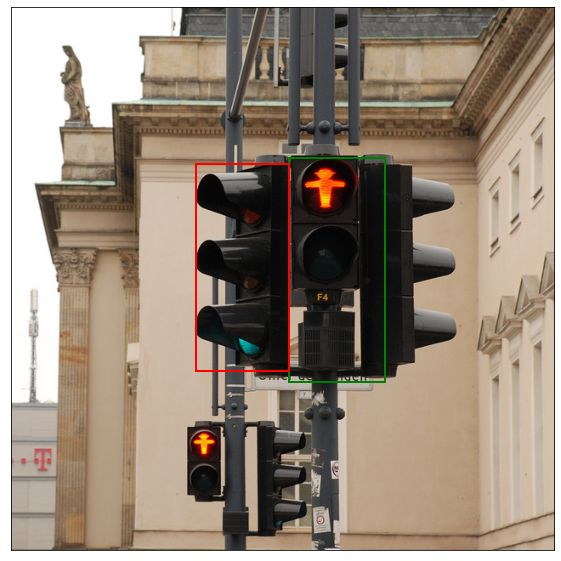


####################################

ref_id: 1645
Annotations:
	 right white truck
	 truck on right
	 right truck

-------------------
refcoco_testB_annsample: truck on right
refcoco_testB_beam_l-na_r-na: white truck
refcoco_testB_greedy_l-na_r-na: truck
refcoco_testB_predfuse_es_l-0-3_r-na: right truck
refcoco_testB_predfuse_es_l-0-5_r-na: right truck
refcoco_testB_predfuse_es_l-0-7_r-na: truck
refcoco_testB_rsa_l-na_r-0-5: white truck
refcoco_testB_rsa_l-na_r-1-0: white truck
refcoco_testB_rsa_l-na_r-5-0: truck
-------------------



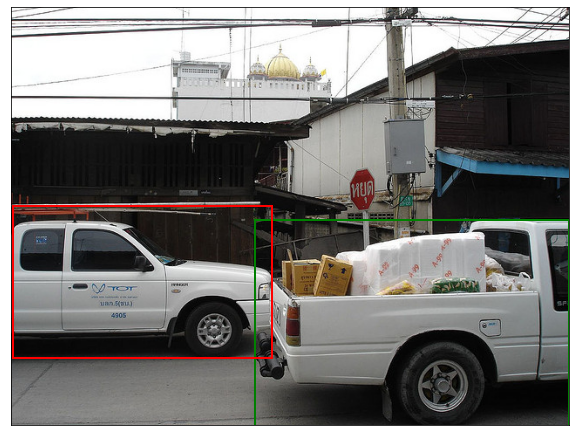


####################################



28    None
43    None
66    None
dtype: object

In [13]:
all_rexps.loc[all_rexps.ref_id.isin(refcoco_testb)].apply(show, axis=1)